In [71]:
# Data Set voorbereiden
import warnings
import pandas as pd
import pyodbc
warnings.simplefilter('ignore')

DBAdventureWorks = {"servername": "localhost\SQLEXPRESS",
      "database": "AdventureWorks2019"}
DBaenc = {"servername": "localhost\SQLEXPRESS",
      "database": "aenc"}
DBNorthwind = {"servername": "localhost\SQLEXPRESS",
      "database": "Northwind"}


connAdventureWorks = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBAdventureWorks['servername'] + 
                             ';DATABASE=' + DBAdventureWorks['database'] + ';Trusted_Connection=yes')
connAenC = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBaenc['servername'] + 
                             ';DATABASE=' + DBaenc['database'] + ';Trusted_Connection=yes')
connNorthwind = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBNorthwind['servername'] + 
                             ';DATABASE=' + DBNorthwind['database'] + ';Trusted_Connection=yes')

export_cursorAdventureWorks = connAdventureWorks.cursor()
export_cursoraenc = connAenC.cursor()
export_cursorNorthwind = connNorthwind.cursor()

# data laden

In [72]:
adventureworks_customers = pd.read_sql_query("SELECT * FROM Sales.Customer", connAdventureWorks)
adventureworks_sales = pd.read_sql_query("SELECT * FROM Sales.SalesOrderDetail", connAdventureWorks)
adventureworks_order_header = pd.read_sql_query("SELECT * FROM Sales.SalesOrderHeader", connAdventureWorks)

aenc_customers = pd.read_sql_query("SELECT * FROM customer", connAenC)
aenc_sales = pd.read_sql_query("SELECT * FROM sales_order_item", connAenC)
aenc_order_header = pd.read_sql_query("SELECT * FROM sales_order", connAenC)

northwind_customers = pd.read_sql_query("SELECT * FROM Customers", connNorthwind)
northwind_sales = pd.read_sql_query("SELECT * FROM [Order Details]", connNorthwind)
northwind_order_header = pd.read_sql_query("SELECT * FROM Orders", connNorthwind)

# data transformeren

In [73]:
# Convert aenc_sales quantity column to int64
aenc_sales = aenc_sales[pd.to_numeric(aenc_sales['quantity'], errors='coerce').notna()]
aenc_sales['Quantity'] = aenc_sales['quantity'].astype('int64')

In [74]:
# Add source to dataframes
adventureworks_customers['Source'] = 'AdventureWorks2019'
aenc_customers['Source'] = 'AenC'
northwind_customers['Source'] = 'Northwind'

In [75]:
# Normalize column names
adventureworks_customers.rename(columns={'CustomerID': 'CustomerID', 'AccountNumber': 'AccountNumber'}, inplace=True)
aenc_customers.rename(columns={'id': 'CustomerID'}, inplace=True)
northwind_customers.rename(columns={'CustomerID': 'CustomerID'}, inplace=True)

In [76]:
# Combine customer data
customers = pd.concat([adventureworks_customers[['CustomerID', 'Source']],
                       aenc_customers[['CustomerID', 'Source']],
                       northwind_customers[['CustomerID', 'Source']]],
                      ignore_index=True)

In [77]:
# Normalize and combine sales data with order headers
adventureworks_sales = adventureworks_sales.merge(adventureworks_order_header[['SalesOrderID', 'CustomerID']], on='SalesOrderID', suffixes=('_adventureworks', '_header'))
aenc_sales = aenc_sales.merge(aenc_order_header[['id', 'cust_id']], left_on='id', right_on='id', suffixes=('_aenc', '_header'))
northwind_sales = northwind_sales.merge(northwind_order_header[['OrderID', 'CustomerID']], on='OrderID', suffixes=('_northwind', '_header'))

adventureworks_sales.rename(columns={'SalesOrderID': 'OrderID', 'CustomerID': 'CustomerID', 'OrderQty': 'Quantity'}, inplace=True)
aenc_sales.rename(columns={'id': 'OrderID', 'prod_id': 'ProductID', 'quantity': 'Quantity', 'cust_id': 'CustomerID'}, inplace=True)
northwind_sales.rename(columns={'OrderID': 'OrderID', 'ProductID': 'ProductID', 'Quantity': 'Quantity'}, inplace=True)

In [78]:
#aenc_sales heeft Quantity 2 keer
aenc_sales = aenc_sales.loc[:,~aenc_sales.columns.duplicated()].copy()

aenc_sales['Quantity'] = aenc_sales['Quantity'].astype('int64')

In [79]:
# Combine sales data
sales = pd.concat([adventureworks_sales[['OrderID', 'CustomerID', 'Quantity', 'ProductID']],
                   aenc_sales[['OrderID', 'CustomerID', 'Quantity', 'ProductID']],
                   northwind_sales[['OrderID', 'CustomerID', 'Quantity', 'ProductID']]],
                  ignore_index=True)

In [80]:
# Group sales data per customer
customer_sales = sales.groupby('CustomerID').agg({'Quantity': 'sum'}).reset_index()
customer_sales.rename(columns={'Quantity': 'TotalPurchases'}, inplace=True)

In [81]:
# Merge customer sales data
customers = customers.merge(customer_sales, on='CustomerID', how='left')

In [82]:
# Drop rows with missing values
customers.dropna(subset=['TotalPurchases'], inplace=True)

In [83]:
# Add dummy variables for Source
customers = pd.get_dummies(customers, columns=['Source'], drop_first=True)

In [84]:
# Prepare basket matrix for frequent item analysis
basket = sales.groupby(['OrderID', 'ProductID']).size().unstack().reset_index().fillna(0).set_index('OrderID')

# Apriori algoritme toepassen

In [85]:
# Convert to binary values
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [101]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

In [107]:
# Generate association rules
min_confidence = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

In [108]:
# Display the rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(714),(707),0.036971,0.093580,0.021581,0.583744,6.237898,0.018122,2.177553,0.871925
1,(715),(707),0.049628,0.093580,0.025376,0.511315,5.463922,0.020731,1.854814,0.859644
2,(716),(707),0.032660,0.093580,0.019123,0.585502,6.256685,0.016066,2.186789,0.868538
3,(738),(707),0.018212,0.093580,0.010168,0.558333,5.966361,0.008464,2.052271,0.847835
4,(859),(707),0.032964,0.093580,0.018303,0.555249,5.933398,0.015218,2.038037,0.859805
...,...,...,...,...,...,...,...,...,...,...
32757,"(883, 876)","(864, 708, 870, 712, 715, 877, 884)",0.011474,0.010138,0.010017,0.873016,86.112299,0.009900,7.795162,0.999859
32758,"(884, 876)","(864, 708, 870, 712, 715, 877, 883)",0.013265,0.010138,0.010017,0.755149,74.486154,0.009882,4.042707,0.999837
32759,"(883, 877)","(864, 708, 870, 712, 715, 876, 884)",0.011565,0.010047,0.010017,0.866142,86.208578,0.009901,7.395531,0.999965
32760,"(884, 877)","(864, 708, 870, 712, 715, 876, 883)",0.011109,0.010047,0.010017,0.901639,89.741717,0.009905,10.064522,0.999966


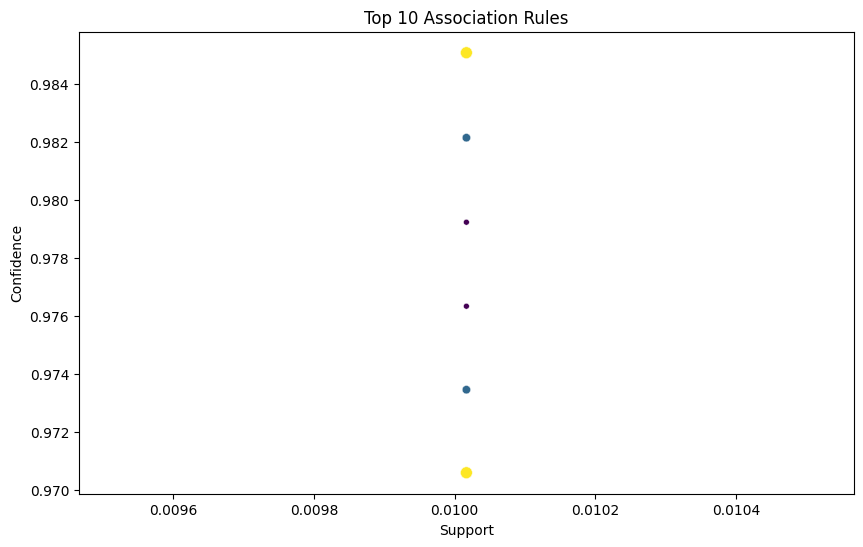

In [109]:
import seaborn as sns

# Visualize the top 10 rules
top_rules = rules.sort_values('lift', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=top_rules, palette='viridis', legend=False)
plt.title('Top 10 Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

In [110]:
# K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the data
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers[['TotalPurchases']])

# Train K-Means model
clustercount = 7
kmeans = KMeans(n_clusters=clustercount, random_state=42)
customers['Cluster'] = kmeans.fit_predict(customers_scaled)

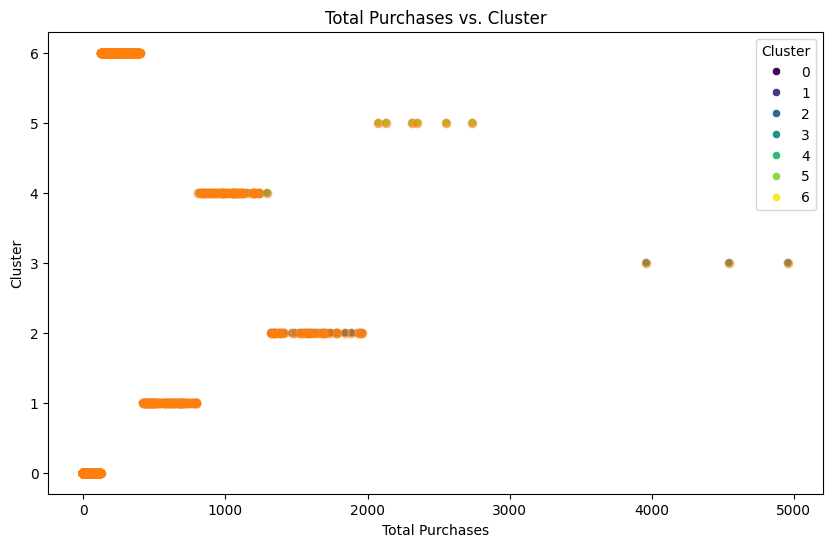

In [111]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPurchases', y='Cluster', hue='Cluster', palette='viridis', data=customers, legend='full')
plt.scatter(customers['TotalPurchases'], customers['Cluster'], alpha=0.5)
plt.xlabel('Total Purchases')
plt.ylabel('Cluster')
plt.title('Total Purchases vs. Cluster')

# Set y-axis to display integer values only
plt.yticks(range(clustercount))

plt.show()